# Variational Autoencoder for STL Objects

WARNING: this notebook was primarily used during the implementation and debug phase of the VAE. Once comp

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) \[[github](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py)\] \[[paper](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/paper/NIPS_paper_2016.pdf)\]. We refer to this VAE as the "Example VAE" in this notebook.

Other sources of inspiration:
* https://github.com/yilei0620/3D_Conditional_Gan/blob/master/ThreeD_AE.py
* https://github.com/Spartey/3D-VAE-GAN-Deep-Learning-Project/blob/master/3D-VAE-WGAN/model.py

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import

In [42]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


thingi = Thingi10k.init10k(pctile=.8)
# apply filter
#thingi.filter_by_id(1351747)
thingi.filter_by_tag('animal')
#thingi.filter_to_just_one()
#thingi = Thingi10k.init10()
#thingi = Thingi10k.init10(pctile=.1)
n_input = len(thingi)
n_input

109

In [89]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, debug=False, ckpt_dir='voxel_vae'
                ,mashup_weight=0.5):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.debug = debug
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        self.mashup_weight = mashup_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        # add ops to this list as a tuple with (<op name>, <op>) to see them executed, returned, and printed
        # to console during execution
        self._debug_ops = list()
        
        # Construct the TensorFlow Graph
        self.encoder, self.enc_mu, self.enc_sig = self._make_encoder(self._input_x, self._keep_prob, self._trainable)
        self.decoder = self._make_decoder(self.encoder, self._trainable)
        self.loss, self.optimizer, self.mean_recon, self.mean_kl = self._make_loss(self._input_x, self.decoder, self.enc_mu, self.enc_sig)

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons_pre = list()
        self.recons_post = list()
        self.losses_kl_div = list()
        self.losses_recon = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
            # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
            # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
            conv1 = tf.layers.batch_normalization(tf.layers.conv3d(input_x,
                                     filters=8,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv1)
            # the Example VAE specifies the activation functions as part of the layer
            # we specify the activation function as a seperate tensor
            # it is unknown if this is the preferred method in Tensorflow, but we know
            # it works from work in the 3D-VAE-GAN notebook
            # we also take advantage of batch_normalization
            # more info here:
            # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
            # with the hope that it gives speed without sacrificing quality
            # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
            # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu

            conv2 = tf.layers.batch_normalization(tf.layers.conv3d(conv1,
                                     filters=16,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv2)

            conv3 = tf.layers.batch_normalization(tf.layers.conv3d(conv2,
                                     filters=32,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv3)

            conv4 = tf.layers.batch_normalization(tf.layers.conv3d(conv3,
                                     filters=64,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv4)

            # Apply one fully-connected layer after Conv3d layers
            # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
            dense1 = tf.layers.batch_normalization(tf.layers.dense(conv4,
                                 units=343,
                                 activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(dense1)
            flatten = tf.layers.flatten(tf.nn.dropout(dense1, keep_prob))
        
            enc_mu = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_mu)
            enc_sig = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_sig)
                                                  
            # epsilon is a random draw from the latent space
            epsilon = tf.random_normal(tf.stack([tf.shape(dense1)[0], self.latent_dim]))
            self._print_shape(epsilon, 'epsilon')
            enc_z = enc_mu + tf.multiply(epsilon, tf.exp(enc_sig))
            self._print_shape(enc_z, 'z')
        return enc_z, enc_mu, enc_sig


        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')

        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')

        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable):
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        self._print_shape(input_z, 'input_z')

        # Why conv3d_transpose instead of conv3d?
        #
        # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
        #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
        #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
        #
        # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
        dense1 = tf.layers.dense(input_z,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='dec_dense1')
        self._print_shape(dense1)
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
        self._print_shape(lrelu1)

        #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
        reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
        self._print_shape(reshape_z)
        #print('reshape_z: ', reshape_z.shape)
        #for value in reshape_z.shape:
        #    print(type(value))

        conv1 = tf.layers.conv3d_transpose(reshape_z,
                                           filters=64,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           # Example VAE does not mention bias
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv1')
        self._print_shape(conv1)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
        self._print_shape(lrelu2)

        conv2 = tf.layers.conv3d_transpose(lrelu2,
                                           filters=32,
                                           kernel_size=[3, 3, 3],
                                           # Example VAE used .5 stride values, but Tensorflow complains
                                           # of being forced to use a float value here
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv2')
        self._print_shape(conv2)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
        self._print_shape(lrelu3)

        conv3 = tf.layers.conv3d_transpose(lrelu3,
                                           filters=16,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           # changed to valid to hit correct dimension
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv3')
        self._print_shape(conv3)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
        self._print_shape(lrelu4)

        conv4 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=8,
                                           kernel_size=[4, 4, 4],
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv4')
        self._print_shape(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
        self._print_shape(lrelu5)

        conv5 = tf.layers.conv3d_transpose(lrelu5,
                                           filters=1,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv5')
        self._print_shape(conv5)
        #decoded_output = tf.nn.tanh(conv5)
        decoded_output = tf.nn.sigmoid(conv5)
        #decoded_output = tf.clip_by_value(decoded_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max decoded_output', tf.math.reduce_max(decoded_output), False)
        #self._add_debug_op('min decoded_output', tf.math.reduce_min(decoded_output), False)
        #self._add_debug_op('mean decoded_output', tf.math.reduce_mean(decoded_output), False)
        #decoded_output = conv5
        self._print_shape(decoded_output)
        
        return decoded_output
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        
        # Weighted binary cross-entropy for use in voxel loss. Allows weighting of false positives relative to false negatives.
        # Nominally set to strongly penalize false negatives
        # we must clip because values of 0 or 1 will cause errors
        #clipped_input = tf.clip_by_value(tf.nn.sigmoid(enc_input), 1e-7, 1.0 - 1e-7)
        clipped_input = tf.clip_by_value(enc_input, 1e-7, 1.0 - 1e-7)
        clipped_output = tf.clip_by_value(dec_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max clipped_input', tf.math.reduce_max(clipped_input), False)
        #self._add_debug_op('min clipped_input', tf.math.reduce_min(clipped_input), False)
        #self._add_debug_op('mean clipped_input', tf.math.reduce_mean(clipped_input), False)
        self._add_debug_op('max clipped_output', tf.math.reduce_max(clipped_output), False)
        self._add_debug_op('min clipped_output', tf.math.reduce_min(clipped_output), False)
        self._add_debug_op('mean clipped_output', tf.math.reduce_mean(clipped_output), False)
        bce = -(98.0 * clipped_input * tf.log(clipped_output) + 2.0 * (1.0 - clipped_input) * tf.log(1.0 - clipped_output)) / 100.0
        #self._add_debug_op('bce', bce, False)
        #bce = tf.keras.backend.binary_crossentropy(enc_output, dec_output)
        
        # Voxel-Wise Reconstruction Loss 
        # Note that the output values are clipped to prevent the BCE from evaluating log(0).
        recon_loss = tf.reduce_mean(bce, 1)
   
        #recon_loss = tf.reduce_sum(tf.squared_difference(
        #    tf.reshape(dec_output, (-1, self.input_dim ** 3)),
        #    tf.reshape(self._input_x, (-1, self.input_dim ** 3))), 1)
        
        kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_kl = tf.reduce_sum(kl_divergence)
        #self._add_debug_op('mean_kl', mean_kl, False)
        mean_recon = tf.reduce_sum(recon_loss)
        #self._add_debug_op('mean_recon', mean_recon, False)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * kl_divergence + self.recon_loss_weight * recon_loss)
        #self._add_debug_op('loss', loss, False)
        # remove kl for fun
        #loss = tf.reduce_mean(self.recon_loss_weight * recon_loss)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

        return loss, optimizer, mean_recon, mean_kl

    def _add_debug_op(self, name, op, newline=True):
        self._debug_ops.append((name, op, newline))
        return

    def _print_debug_ops(self, results):
        if self.debug:
            for i, debug_op in enumerate(self._debug_ops):
                msg = 'DEBUG_OP "{}": '.format(debug_op[0])
                if len(debug_op) > 2 and debug_op[2]:
                    msg += '\n'
                msg += '{}'.format(results[i])
                print(msg)
        return

    def train(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1, viz_data=None):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                if self.verbose:
                    print('Epoch: {}, Batch: {}, Elapsed time: {:.2f} mins'.format(epoch_num, batch_num, (time.time() - start) / 60))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

                    ops = tuple([self.optimizer, self.loss, self.mean_kl, self.mean_recon] + 
                                [op for name, op, _ in self._debug_ops])
                    results = self.sess.run(
                        ops,
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                    _, loss, kl_divergence, recon_loss = results[:4]
                    self._print_debug_ops(results[4:])
                    
                if self.verbose:
                    #print('\tKL Divergence = {:.5f}, Reconstruction Loss = {:.5f}'.format(kl_divergence, recon_loss))
                    print('\tKL Divergence = {}, Reconstruction Loss = {}'.format(kl_divergence, recon_loss))
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "Loss = {:.5f}, ".format(loss) + 
                      "KL Divergence = {:.5f}, ".format(kl_divergence) +
                      "Reconstruction Loss = {:.5f}, ".format(recon_loss) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                if viz_data is not None:
                    self._print_shape(viz_data, 'Example shape (before reshape)')
                    recon_input = np.reshape(viz_data, (1, self.input_dim, self.input_dim, self.input_dim, 1))
                    self._print_shape(recon_input, 'Example shape')

                    # generate!
                    recon = self.reconstruct(recon_input)
                    self._print_shape(recon, 'Recon')

                    # prepare for plotting
                    recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                    self._print_shape(recon_input, 'Example shape (for plotting)')
                    recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                    self._print_shape(recon, 'Recon (for plotting)')
                    # network outputs decimals; here we force them to True/False for plotting
                    self.recons_pre.append(recon)
                    recon = recon > 0.5
                    self.recons_post.append(recon)
                    # replace all nans with zeros
                    #recon = np.nan_to_num(recon)

                    # save the generated object in case we wish to review later
                    path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))

                    # visualize
                    self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.decoder] + [op for name, op, _ in self._debug_ops])
                    
        results = self.sess.run(ops, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        
        decoded = results[0]
        self._print_debug_ops(results[1:])
                    
        return decoded
    
    ### test the mashup ###########
    
    def interp(v1, v2, steps):
        vecs = []
        step = (v2-v1)/steps
        for i in range(steps):
            vecs.append(v1+step*i)
        vecs.append(v2)

        return vecs
    
    def mashup(self, input_x1, input_x2):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.encoder] + [self.decoder] + [op for name, op, _ in self._debug_ops])

        # first 3d object
        result_1 = self.sess.run(ops, 
            feed_dict={self._input_x: input_x1, self._keep_prob: 1.0, self._trainable: False})
        # second 3d object
        result_2 = self.sess.run(ops, 
            feed_dict={self._input_x: input_x2, self._keep_prob: 1.0, self._trainable: False})

        # extract vector space for each
        encoder_1 = result_1[0]
        encoder_2 = result_2[0]
        # add two vector space into one, use interpolation?
#         new_vector = self.mashup_weight*encoder_1 + (1-self.mashup_weight)*encoder_2
        new_vector = interp(encoder_1, encoder_2, 9)[1] # generate 9 arrays, use the 1 interpolated; should use variable
                                                        # so that we could plot all of them, from similar to object 1 to object 2
        # construct the object using derived vector space above
        results = self.sess.run(self.decoder, 
            feed_dict={self.encoder: new_vector, self._trainable: False})
        decoded = results[0]

        return decoded
    ##################################################################
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


## Training

The model is having issues producing an output that is recognizable.

Experiments:
* Large & small datasets produce the same result
* latent_dim variations have no effect
* Too high of a learning rate causes the loss to go down then up and sometimes fluctuate
* Removing dropout (keep_prob=1.0) with lr=0.00001 on a single training example causes loss to go down as expected but output is still not recognizable
* Upping recon_loss_weight seems to cause more variation in decoded output
* Severe upping of recon_loss_weight (recon=5, kl=5e-4) delivered loss of ~5 after 500 epochs on a single training example with 20 input_repeats
* 500 epochs with above settings and RMSPropOptimizer achieved loss of <1 after about 200 epochs; viz still unimpressive
* Increasing recon_loss_weight to 5e5 and dumping recon loss and kl divergence values reveals that recon loss is diminishing. Question: what is the input to recon loss? an array of 1s and 0s or TRUEs and FALSEs? A: 1s and 0s
* Using weight binary cross entropy for recon loss as according to Example VAE shows same loss reduction pattern with still unimpressive recon
* Equalized loss weights yielded no change (at 100 epochs on one square example with 50 input_repeats, viz was all 1s)
* By dumping out counts of True vs False of each recon, I can see that False goes down while True goes up to the point where they are almost all Trues after 50 epochs
* Run through all training examples produces loss of nan
* Added homebaked debug_ops and discovered that the dec_output is nan and not the loss functions!
* latent_dim=100, lr=0.0001, dataset=animals, keep_prob=1.0, kl_loss_weight=1, recon_loss_weight=1e4, batch_size=22, epochs=50 -- kind of reconstructed 126660 the bird! Used a threshold of 0.085 though.

Notes:

* The model is assigning a high probability to the outside layer of the cube. As you decrease the threshold, that outside layer begins to build. Why? How many training examples even have voxels in those locations? 
* You would expect the center voxel to always have the highest probability as all input is centered and thus would fill that voxel.

Todo:
* Move model into .py file
* Move training config into .py file that can be edited/saved
* Improve model saving/restoring/labeling
* *Combine VAE with GAN for VAE-GAN!*

Num input = 109
Num batches per epoch = 4.95


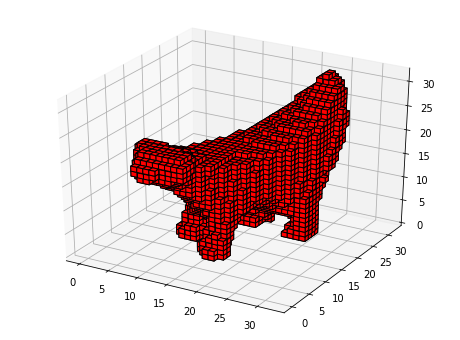

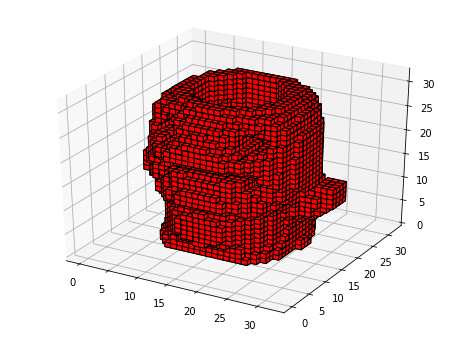

In [47]:
VOXELS_DIM = 32
BATCH_SIZE = 22
print('Num input = {}'.format(n_input))
print('Num batches per epoch = {:.2f}'.format(n_input / BATCH_SIZE))
training_example1 = thingi.get_voxels(VOXELS_DIM, stl_file=thingi.get_stl_path(stl_id=101902))
plot_voxels(training_example1)
training_example2 = thingi.get_voxels(VOXELS_DIM, stl_file=thingi.get_stl_path(stl_id=299291)) 
plot_voxels(training_example2)

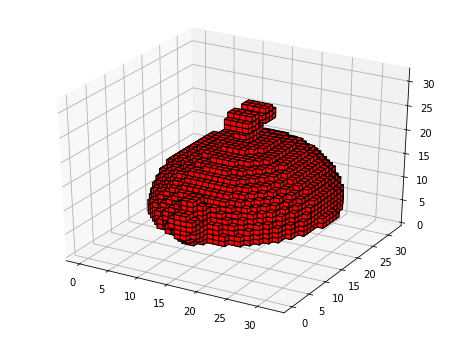

In [46]:
training_example2 = thingi.get_voxels(VOXELS_DIM, stl_file=thingi.get_stl_path(stl_id=81137)) # 299291
plot_voxels(training_example2)

encoder/batch_normalization/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 100)
encoder/batch_normalization_6/batchnorm/add_1:0: (?, 100)
epsilon: (?, 100)
z: (?, 100)
input_z: (?, 100)
dec_dense1/BiasAdd:0: (?, 343)
Elu:0: (?, 343)
reshape_z:0: (?, 7, 7, 7, 1)
dec_conv1/conv3d_transpose:0: (?, 7, 7, 7, 64)
dec_lrelu2:0: (?, 7, 7, 7, 64)
dec_conv2/conv3d_transpose:0: (?, 15, 15, 15, 32)
dec_lrelu3:0: (?, 15, 15, 15, 32)
dec_conv3/conv3d_transpose:0: (?, 15, 15, 15, 16)
dec_lrelu4:0: (?, 15, 15, 15, 16)
dec_conv4/conv3d_transpose:0: (?, 32, 32, 32, 8)
dec_lrelu5:0: (?, 32, 32, 32, 8)
dec_conv5/conv3d_transpose:0: (?, 32, 32, 32, 1)
Sigmoid:0: (?, 32, 32, 32, 1)
Epoch: 0, Batch:

DEBUG_OP "max clipped_output": 0.9999723434448242
DEBUG_OP "min clipped_output": 0.11025192588567734
DEBUG_OP "mean clipped_output": 0.6671719551086426
	KL Divergence = 374.2477722167969, Reconstruction Loss = 868.4983520507812
Epoch: 7, Batch: 0, Elapsed time: 0.94 mins
DEBUG_OP "max clipped_output": 0.9999980926513672
DEBUG_OP "min clipped_output": 0.10569074749946594
DEBUG_OP "mean clipped_output": 0.7028454542160034
	KL Divergence = 357.703369140625, Reconstruction Loss = 793.3638916015625
Epoch: 7, Batch: 1, Elapsed time: 0.98 mins
DEBUG_OP "max clipped_output": 0.9999992847442627
DEBUG_OP "min clipped_output": 0.09160801023244858
DEBUG_OP "mean clipped_output": 0.6666896939277649
	KL Divergence = 391.87188720703125, Reconstruction Loss = 849.9830322265625
Epoch: 7, Batch: 2, Elapsed time: 1.01 mins
DEBUG_OP "max clipped_output": 0.9999992847442627
DEBUG_OP "min clipped_output": 0.07059864699840546
DEBUG_OP "mean clipped_output": 0.6513569355010986
	KL Divergence = 417.51318359375

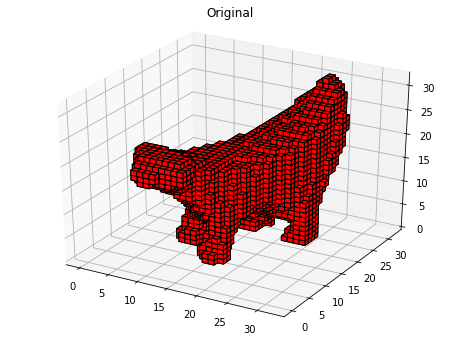

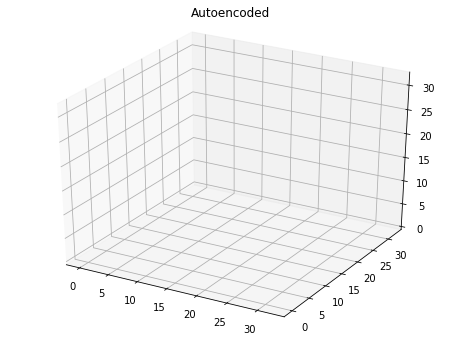

Epoch: 10, Batch: 0, Elapsed time: 1.42 mins
DEBUG_OP "max clipped_output": 0.9999926090240479
DEBUG_OP "min clipped_output": 0.018690308555960655
DEBUG_OP "mean clipped_output": 0.6339787840843201
	KL Divergence = 596.8319091796875, Reconstruction Loss = 688.59228515625
Epoch: 10, Batch: 1, Elapsed time: 1.45 mins
DEBUG_OP "max clipped_output": 0.9999986886978149
DEBUG_OP "min clipped_output": 0.008514180779457092
DEBUG_OP "mean clipped_output": 0.6152191162109375
	KL Divergence = 499.04266357421875, Reconstruction Loss = 766.14892578125
Epoch: 10, Batch: 2, Elapsed time: 1.48 mins
DEBUG_OP "max clipped_output": 0.9999922513961792
DEBUG_OP "min clipped_output": 0.00878974236547947
DEBUG_OP "mean clipped_output": 0.5907877087593079
	KL Divergence = 667.010009765625, Reconstruction Loss = 697.099853515625
Epoch: 10, Batch: 3, Elapsed time: 1.51 mins
DEBUG_OP "max clipped_output": 0.9999498128890991
DEBUG_OP "min clipped_output": 0.008920211344957352
DEBUG_OP "mean clipped_output": 0.555

DEBUG_OP "max clipped_output": 0.9999911785125732
DEBUG_OP "min clipped_output": 0.00028172071324661374
DEBUG_OP "mean clipped_output": 0.4524066746234894
	KL Divergence = 827.169921875, Reconstruction Loss = 521.7352294921875
Epoch: 17, Batch: 3, Elapsed time: 2.51 mins
DEBUG_OP "max clipped_output": 0.999913215637207
DEBUG_OP "min clipped_output": 0.0003940598980989307
DEBUG_OP "mean clipped_output": 0.447541743516922
	KL Divergence = 948.427978515625, Reconstruction Loss = 562.753173828125
Epoch: 18, Batch: 0, Elapsed time: 2.54 mins
DEBUG_OP "max clipped_output": 0.9999901056289673
DEBUG_OP "min clipped_output": 2.5738416297826916e-05
DEBUG_OP "mean clipped_output": 0.45731431245803833
	KL Divergence = 756.6112670898438, Reconstruction Loss = 521.78564453125
Epoch: 18, Batch: 1, Elapsed time: 2.58 mins
DEBUG_OP "max clipped_output": 0.999966025352478
DEBUG_OP "min clipped_output": 4.585179704008624e-05
DEBUG_OP "mean clipped_output": 0.4574226140975952
	KL Divergence = 812.58990478

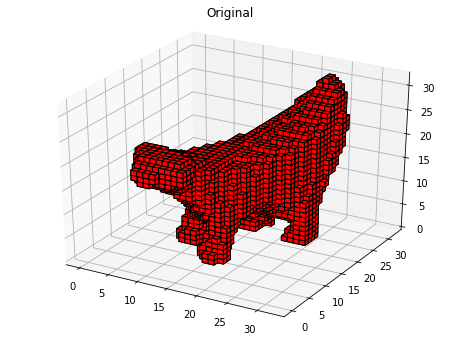

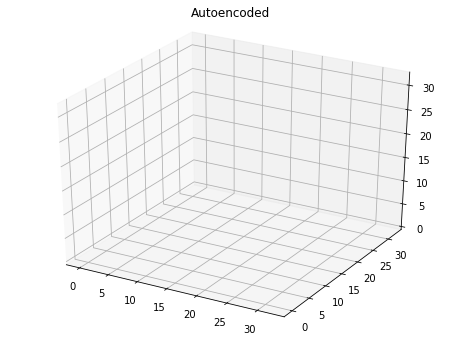

Epoch: 20, Batch: 0, Elapsed time: 2.88 mins
DEBUG_OP "max clipped_output": 0.9999910593032837
DEBUG_OP "min clipped_output": 2.1252148144412786e-05
DEBUG_OP "mean clipped_output": 0.43176087737083435
	KL Divergence = 769.408447265625, Reconstruction Loss = 497.11651611328125
Epoch: 20, Batch: 1, Elapsed time: 2.91 mins
DEBUG_OP "max clipped_output": 0.9999768733978271
DEBUG_OP "min clipped_output": 4.494140739552677e-05
DEBUG_OP "mean clipped_output": 0.42646676301956177
	KL Divergence = 817.1054077148438, Reconstruction Loss = 502.37591552734375
Epoch: 20, Batch: 2, Elapsed time: 2.94 mins
DEBUG_OP "max clipped_output": 0.999958872795105
DEBUG_OP "min clipped_output": 8.106088353088126e-05
DEBUG_OP "mean clipped_output": 0.4246808886528015
	KL Divergence = 930.10791015625, Reconstruction Loss = 455.41937255859375
Epoch: 20, Batch: 3, Elapsed time: 2.98 mins
DEBUG_OP "max clipped_output": 0.9999405145645142
DEBUG_OP "min clipped_output": 7.508120324928313e-05
DEBUG_OP "mean clipped_ou

DEBUG_OP "max clipped_output": 0.9999525547027588
DEBUG_OP "min clipped_output": 2.326879621250555e-05
DEBUG_OP "mean clipped_output": 0.3904862105846405
	KL Divergence = 832.7152709960938, Reconstruction Loss = 414.96771240234375
Epoch: 27, Batch: 3, Elapsed time: 3.94 mins
DEBUG_OP "max clipped_output": 0.9997883439064026
DEBUG_OP "min clipped_output": 2.6249528673361056e-05
DEBUG_OP "mean clipped_output": 0.38839009404182434
	KL Divergence = 1126.076171875, Reconstruction Loss = 460.71136474609375
Epoch: 28, Batch: 0, Elapsed time: 3.97 mins
DEBUG_OP "max clipped_output": 0.9999880790710449
DEBUG_OP "min clipped_output": 5.08179846292478e-06
DEBUG_OP "mean clipped_output": 0.39274007081985474
	KL Divergence = 960.179931640625, Reconstruction Loss = 419.046875
Epoch: 28, Batch: 1, Elapsed time: 4.01 mins
DEBUG_OP "max clipped_output": 0.999982476234436
DEBUG_OP "min clipped_output": 4.905885816697264e-06
DEBUG_OP "mean clipped_output": 0.38846465945243835
	KL Divergence = 966.4188232

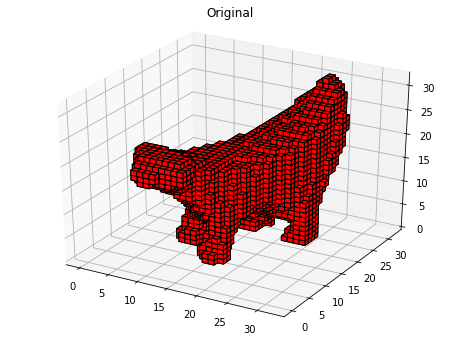

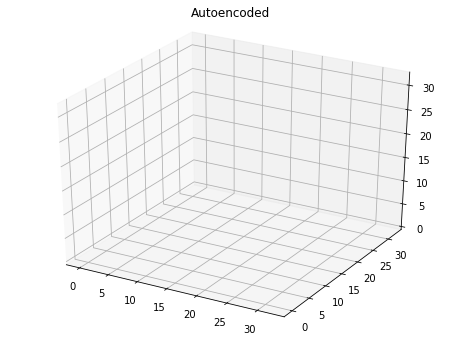

Epoch: 30, Batch: 0, Elapsed time: 4.31 mins
DEBUG_OP "max clipped_output": 0.9999918937683105
DEBUG_OP "min clipped_output": 5.599451014859369e-06
DEBUG_OP "mean clipped_output": 0.37928417325019836
	KL Divergence = 894.6935424804688, Reconstruction Loss = 434.1504821777344
Epoch: 30, Batch: 1, Elapsed time: 4.35 mins
DEBUG_OP "max clipped_output": 0.9999821186065674
DEBUG_OP "min clipped_output": 4.7908156375342514e-06
DEBUG_OP "mean clipped_output": 0.38096705079078674
	KL Divergence = 1060.4371337890625, Reconstruction Loss = 430.0009765625
Epoch: 30, Batch: 2, Elapsed time: 4.38 mins
DEBUG_OP "max clipped_output": 0.9999551773071289
DEBUG_OP "min clipped_output": 9.240206964022946e-06
DEBUG_OP "mean clipped_output": 0.3810267448425293
	KL Divergence = 845.1275634765625, Reconstruction Loss = 391.48651123046875
Epoch: 30, Batch: 3, Elapsed time: 4.42 mins
DEBUG_OP "max clipped_output": 0.9999426603317261
DEBUG_OP "min clipped_output": 2.970794048451353e-05
DEBUG_OP "mean clipped_ou

DEBUG_OP "max clipped_output": 0.9999902248382568
DEBUG_OP "min clipped_output": 9.32783314055996e-06
DEBUG_OP "mean clipped_output": 0.36534789204597473
	KL Divergence = 850.2122192382812, Reconstruction Loss = 367.0703125
Epoch: 37, Batch: 3, Elapsed time: 5.38 mins
DEBUG_OP "max clipped_output": 0.9999358654022217
DEBUG_OP "min clipped_output": 4.4026241994288284e-06
DEBUG_OP "mean clipped_output": 0.3683987557888031
	KL Divergence = 1101.0216064453125, Reconstruction Loss = 390.60345458984375
Epoch: 38, Batch: 0, Elapsed time: 5.41 mins
DEBUG_OP "max clipped_output": 0.9999933242797852
DEBUG_OP "min clipped_output": 1.1881576256200788e-06
DEBUG_OP "mean clipped_output": 0.3603823781013489
	KL Divergence = 923.81689453125, Reconstruction Loss = 356.11285400390625
Epoch: 38, Batch: 1, Elapsed time: 5.45 mins
DEBUG_OP "max clipped_output": 0.9999899864196777
DEBUG_OP "min clipped_output": 4.93416473545949e-06
DEBUG_OP "mean clipped_output": 0.34575986862182617
	KL Divergence = 886.016

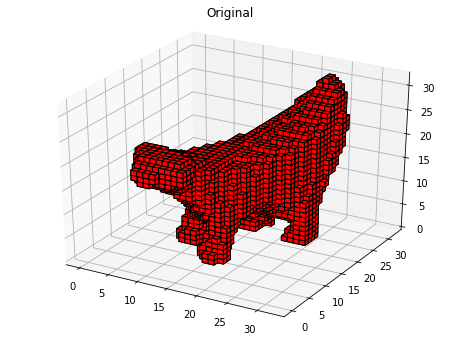

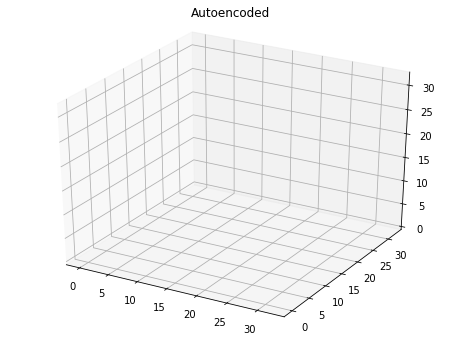

Epoch: 40, Batch: 0, Elapsed time: 5.74 mins
DEBUG_OP "max clipped_output": 0.9999755620956421
DEBUG_OP "min clipped_output": 4.002494279120583e-06
DEBUG_OP "mean clipped_output": 0.34349390864372253
	KL Divergence = 1044.4473876953125, Reconstruction Loss = 352.39996337890625
Epoch: 40, Batch: 1, Elapsed time: 5.78 mins
DEBUG_OP "max clipped_output": 0.9999911785125732
DEBUG_OP "min clipped_output": 2.400294761173427e-06
DEBUG_OP "mean clipped_output": 0.34749695658683777
	KL Divergence = 959.299072265625, Reconstruction Loss = 392.08660888671875
Epoch: 40, Batch: 2, Elapsed time: 5.81 mins
DEBUG_OP "max clipped_output": 0.9999880790710449
DEBUG_OP "min clipped_output": 3.2529585496376967e-06
DEBUG_OP "mean clipped_output": 0.3445585370063782
	KL Divergence = 888.4752807617188, Reconstruction Loss = 379.8936767578125
Epoch: 40, Batch: 3, Elapsed time: 5.84 mins
DEBUG_OP "max clipped_output": 0.9999837875366211
DEBUG_OP "min clipped_output": 5.058906936028507e-06
DEBUG_OP "mean clipped

DEBUG_OP "max clipped_output": 0.9999918937683105
DEBUG_OP "min clipped_output": 2.4519140424672514e-06
DEBUG_OP "mean clipped_output": 0.34276315569877625
	KL Divergence = 1018.805419921875, Reconstruction Loss = 339.97540283203125
Epoch: 47, Batch: 3, Elapsed time: 6.80 mins
DEBUG_OP "max clipped_output": 0.99994957447052
DEBUG_OP "min clipped_output": 3.0814996989647625e-06
DEBUG_OP "mean clipped_output": 0.3475162386894226
	KL Divergence = 1187.29736328125, Reconstruction Loss = 355.11505126953125
Epoch: 48, Batch: 0, Elapsed time: 6.84 mins
DEBUG_OP "max clipped_output": 0.9999793767929077
DEBUG_OP "min clipped_output": 6.347997327793564e-07
DEBUG_OP "mean clipped_output": 0.3394438326358795
	KL Divergence = 916.6141357421875, Reconstruction Loss = 330.9002685546875
Epoch: 48, Batch: 1, Elapsed time: 6.87 mins
DEBUG_OP "max clipped_output": 0.9999837875366211
DEBUG_OP "min clipped_output": 1.4612786571888137e-06
DEBUG_OP "mean clipped_output": 0.33954155445098877
	KL Divergence = 

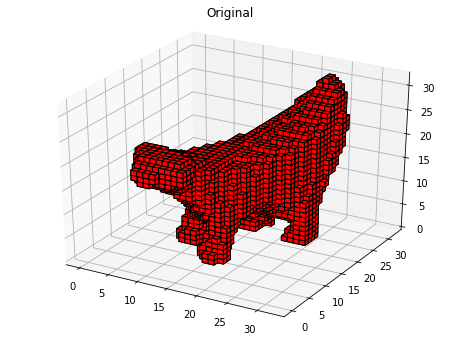

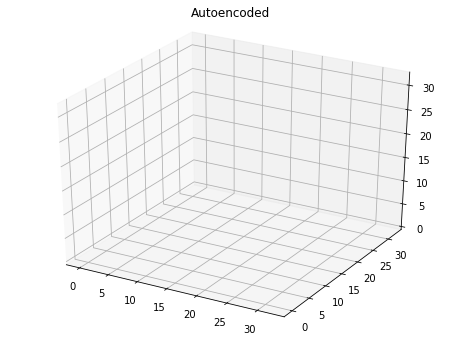

Model saved in path: C:\Users\cynth\desktop\3d-form\src\..\models\voxel_vae\model_epoch-49.ckpt
Epoch: 50, Batch: 0, Elapsed time: 7.18 mins
DEBUG_OP "max clipped_output": 0.9999864101409912
DEBUG_OP "min clipped_output": 1.2623974043890485e-06
DEBUG_OP "mean clipped_output": 0.3339114189147949
	KL Divergence = 908.1919555664062, Reconstruction Loss = 352.2703857421875
Epoch: 50, Batch: 1, Elapsed time: 7.21 mins
DEBUG_OP "max clipped_output": 0.999988317489624
DEBUG_OP "min clipped_output": 9.85879296422354e-07
DEBUG_OP "mean clipped_output": 0.33852675557136536
	KL Divergence = 1028.9725341796875, Reconstruction Loss = 353.9928894042969
Epoch: 50, Batch: 2, Elapsed time: 7.25 mins
DEBUG_OP "max clipped_output": 0.9999821186065674
DEBUG_OP "min clipped_output": 5.024586698709754e-06
DEBUG_OP "mean clipped_output": 0.329588919878006
	KL Divergence = 886.3612060546875, Reconstruction Loss = 338.71539306640625
Epoch: 50, Batch: 3, Elapsed time: 7.28 mins
DEBUG_OP "max clipped_output": 0.

DEBUG_OP "max clipped_output": 0.9999947547912598
DEBUG_OP "min clipped_output": 1.0453105687702191e-06
DEBUG_OP "mean clipped_output": 0.3170371353626251
	KL Divergence = 885.4818115234375, Reconstruction Loss = 329.5516357421875
Epoch: 57, Batch: 3, Elapsed time: 8.24 mins
DEBUG_OP "max clipped_output": 0.9999847412109375
DEBUG_OP "min clipped_output": 1.0090219575431547e-06
DEBUG_OP "mean clipped_output": 0.3281521499156952
	KL Divergence = 1098.124755859375, Reconstruction Loss = 349.97735595703125
Epoch: 58, Batch: 0, Elapsed time: 8.27 mins
DEBUG_OP "max clipped_output": 0.9999892711639404
DEBUG_OP "min clipped_output": 5.604813964055211e-07
DEBUG_OP "mean clipped_output": 0.32274129986763
	KL Divergence = 1008.1071166992188, Reconstruction Loss = 304.60137939453125
Epoch: 58, Batch: 1, Elapsed time: 8.30 mins
DEBUG_OP "max clipped_output": 0.999996542930603
DEBUG_OP "min clipped_output": 8.391830306209158e-07
DEBUG_OP "mean clipped_output": 0.3164620101451874
	KL Divergence = 10

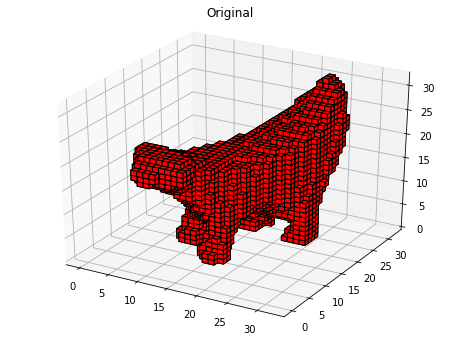

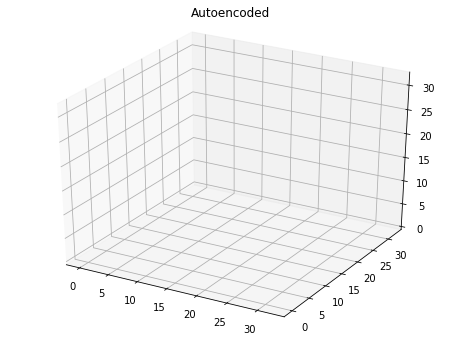

Epoch: 60, Batch: 0, Elapsed time: 8.61 mins
DEBUG_OP "max clipped_output": 0.9999946355819702
DEBUG_OP "min clipped_output": 4.026545923352387e-07
DEBUG_OP "mean clipped_output": 0.32528790831565857
	KL Divergence = 1021.8595581054688, Reconstruction Loss = 292.2025451660156
Epoch: 60, Batch: 1, Elapsed time: 8.64 mins
DEBUG_OP "max clipped_output": 0.9999964237213135
DEBUG_OP "min clipped_output": 6.999204629209999e-07
DEBUG_OP "mean clipped_output": 0.32606035470962524
	KL Divergence = 947.7055053710938, Reconstruction Loss = 344.22772216796875
Epoch: 60, Batch: 2, Elapsed time: 8.68 mins
DEBUG_OP "max clipped_output": 0.999991774559021
DEBUG_OP "min clipped_output": 1.4042491329746554e-06
DEBUG_OP "mean clipped_output": 0.31812217831611633
	KL Divergence = 819.2731323242188, Reconstruction Loss = 327.5282287597656
Epoch: 60, Batch: 3, Elapsed time: 8.71 mins
DEBUG_OP "max clipped_output": 0.9999762773513794
DEBUG_OP "min clipped_output": 6.179074603096524e-07
DEBUG_OP "mean clipped

DEBUG_OP "max clipped_output": 0.9999974966049194
DEBUG_OP "min clipped_output": 6.253455921978457e-07
DEBUG_OP "mean clipped_output": 0.31141185760498047
	KL Divergence = 872.7406005859375, Reconstruction Loss = 326.22467041015625
Epoch: 67, Batch: 3, Elapsed time: 9.67 mins
DEBUG_OP "max clipped_output": 0.9999972581863403
DEBUG_OP "min clipped_output": 4.946056719745684e-07
DEBUG_OP "mean clipped_output": 0.3190639913082123
	KL Divergence = 1291.7669677734375, Reconstruction Loss = 325.8067321777344
Epoch: 68, Batch: 0, Elapsed time: 9.71 mins
DEBUG_OP "max clipped_output": 0.9999949932098389
DEBUG_OP "min clipped_output": 6.36448532986833e-07
DEBUG_OP "mean clipped_output": 0.30422601103782654
	KL Divergence = 952.18408203125, Reconstruction Loss = 299.17987060546875
Epoch: 68, Batch: 1, Elapsed time: 9.74 mins
DEBUG_OP "max clipped_output": 0.9999983310699463
DEBUG_OP "min clipped_output": 7.551391263405094e-07
DEBUG_OP "mean clipped_output": 0.3207158148288727
	KL Divergence = 10

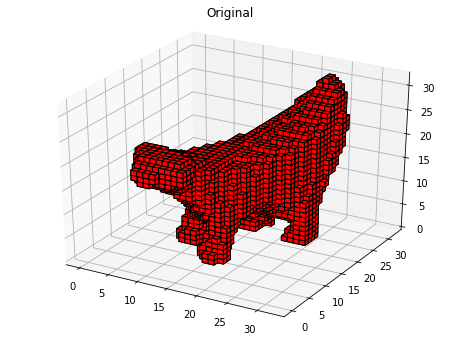

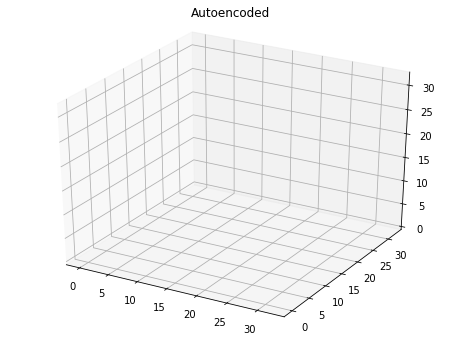

Epoch: 70, Batch: 0, Elapsed time: 10.05 mins
DEBUG_OP "max clipped_output": 0.9999920129776001
DEBUG_OP "min clipped_output": 6.031477255419304e-07
DEBUG_OP "mean clipped_output": 0.3097493052482605
	KL Divergence = 991.9166259765625, Reconstruction Loss = 278.18927001953125
Epoch: 70, Batch: 1, Elapsed time: 10.08 mins
DEBUG_OP "max clipped_output": 0.9999971389770508
DEBUG_OP "min clipped_output": 4.4073360072616197e-07
DEBUG_OP "mean clipped_output": 0.31823837757110596
	KL Divergence = 1014.569091796875, Reconstruction Loss = 306.0750427246094
Epoch: 70, Batch: 2, Elapsed time: 10.11 mins
DEBUG_OP "max clipped_output": 0.9999935626983643
DEBUG_OP "min clipped_output": 1.456760628570919e-06
DEBUG_OP "mean clipped_output": 0.3069894015789032
	KL Divergence = 832.9374389648438, Reconstruction Loss = 306.3992004394531
Epoch: 70, Batch: 3, Elapsed time: 10.15 mins
DEBUG_OP "max clipped_output": 0.9999905824661255
DEBUG_OP "min clipped_output": 6.897674325045955e-07
DEBUG_OP "mean clipp

DEBUG_OP "max clipped_output": 0.9999985694885254
DEBUG_OP "min clipped_output": 8.387917773688969e-07
DEBUG_OP "mean clipped_output": 0.2945311665534973
	KL Divergence = 858.2755126953125, Reconstruction Loss = 287.1278991699219
Epoch: 77, Batch: 3, Elapsed time: 11.11 mins
DEBUG_OP "max clipped_output": 0.9999948740005493
DEBUG_OP "min clipped_output": 4.929358397021133e-07
DEBUG_OP "mean clipped_output": 0.3078499734401703
	KL Divergence = 1103.7679443359375, Reconstruction Loss = 289.768798828125
Epoch: 78, Batch: 0, Elapsed time: 11.14 mins
DEBUG_OP "max clipped_output": 0.9999985694885254
DEBUG_OP "min clipped_output": 2.786504467167106e-07
DEBUG_OP "mean clipped_output": 0.2961093783378601
	KL Divergence = 938.307373046875, Reconstruction Loss = 272.9146423339844
Epoch: 78, Batch: 1, Elapsed time: 11.18 mins
DEBUG_OP "max clipped_output": 0.9999986886978149
DEBUG_OP "min clipped_output": 3.225002274120925e-07
DEBUG_OP "mean clipped_output": 0.30443307757377625
	KL Divergence = 1

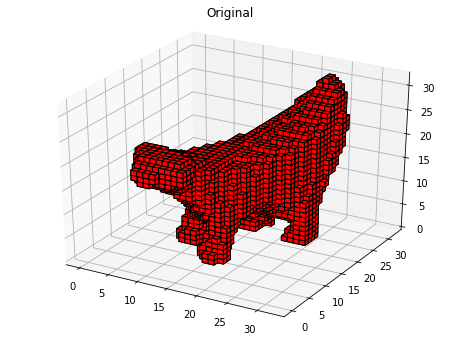

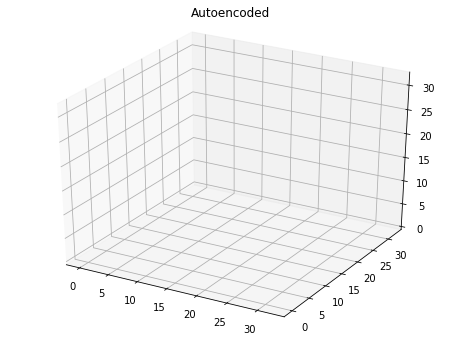

Epoch: 80, Batch: 0, Elapsed time: 11.47 mins
DEBUG_OP "max clipped_output": 0.9999992847442627
DEBUG_OP "min clipped_output": 1.0000000116860974e-07
DEBUG_OP "mean clipped_output": 0.30280637741088867
	KL Divergence = 977.9362182617188, Reconstruction Loss = 273.0705261230469
Epoch: 80, Batch: 1, Elapsed time: 11.52 mins
DEBUG_OP "max clipped_output": 0.9999994039535522
DEBUG_OP "min clipped_output": 8.304501761813299e-07
DEBUG_OP "mean clipped_output": 0.2961268723011017
	KL Divergence = 930.6519775390625, Reconstruction Loss = 315.549072265625
Epoch: 80, Batch: 2, Elapsed time: 11.57 mins
DEBUG_OP "max clipped_output": 0.9999979734420776
DEBUG_OP "min clipped_output": 2.2289549406195874e-07
DEBUG_OP "mean clipped_output": 0.29749566316604614
	KL Divergence = 908.1780395507812, Reconstruction Loss = 298.3458251953125
Epoch: 80, Batch: 3, Elapsed time: 11.62 mins
DEBUG_OP "max clipped_output": 0.999995231628418
DEBUG_OP "min clipped_output": 6.005940349496086e-07
DEBUG_OP "mean clippe

DEBUG_OP "max clipped_output": 0.9999996423721313
DEBUG_OP "min clipped_output": 2.4584036850683333e-07
DEBUG_OP "mean clipped_output": 0.289341002702713
	KL Divergence = 892.65576171875, Reconstruction Loss = 276.75164794921875
Epoch: 87, Batch: 3, Elapsed time: 12.73 mins
DEBUG_OP "max clipped_output": 0.9999966621398926
DEBUG_OP "min clipped_output": 1.7512779493245034e-07
DEBUG_OP "mean clipped_output": 0.3040969967842102
	KL Divergence = 1142.9310302734375, Reconstruction Loss = 282.2674560546875
Epoch: 88, Batch: 0, Elapsed time: 12.76 mins
DEBUG_OP "max clipped_output": 0.9999963045120239
DEBUG_OP "min clipped_output": 1.7097619320338708e-07
DEBUG_OP "mean clipped_output": 0.2915589511394501
	KL Divergence = 1014.1354370117188, Reconstruction Loss = 254.1124267578125
Epoch: 88, Batch: 1, Elapsed time: 12.80 mins
DEBUG_OP "max clipped_output": 0.9999990463256836
DEBUG_OP "min clipped_output": 1.534214675302792e-07
DEBUG_OP "mean clipped_output": 0.29706165194511414
	KL Divergence

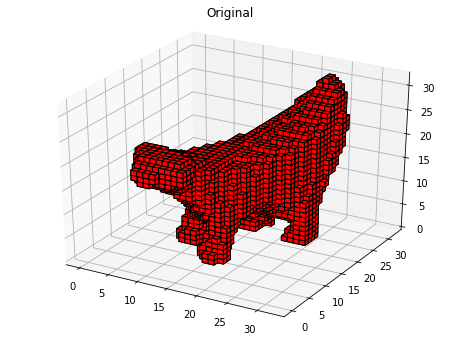

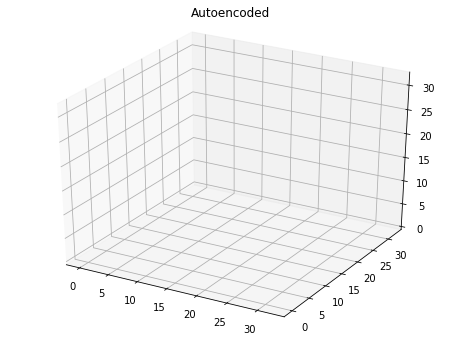

Epoch: 90, Batch: 0, Elapsed time: 13.11 mins
DEBUG_OP "max clipped_output": 0.9999983310699463
DEBUG_OP "min clipped_output": 1.0000000116860974e-07
DEBUG_OP "mean clipped_output": 0.2876066565513611
	KL Divergence = 1009.10693359375, Reconstruction Loss = 251.46328735351562
Epoch: 90, Batch: 1, Elapsed time: 13.16 mins
DEBUG_OP "max clipped_output": 0.9999990463256836
DEBUG_OP "min clipped_output": 2.9251063438096025e-07
DEBUG_OP "mean clipped_output": 0.2938900291919708
	KL Divergence = 985.7677612304688, Reconstruction Loss = 285.3367919921875
Epoch: 90, Batch: 2, Elapsed time: 13.20 mins
DEBUG_OP "max clipped_output": 0.9999992847442627
DEBUG_OP "min clipped_output": 1.9303026022043923e-07
DEBUG_OP "mean clipped_output": 0.28275740146636963
	KL Divergence = 847.1428833007812, Reconstruction Loss = 269.4250183105469
Epoch: 90, Batch: 3, Elapsed time: 13.25 mins
DEBUG_OP "max clipped_output": 0.9999974966049194
DEBUG_OP "min clipped_output": 1.0145686957230282e-07
DEBUG_OP "mean cli

DEBUG_OP "max clipped_output": 0.9999991655349731
DEBUG_OP "min clipped_output": 1.0420494334084651e-07
DEBUG_OP "mean clipped_output": 0.27712222933769226
	KL Divergence = 825.8673095703125, Reconstruction Loss = 258.9120178222656
Epoch: 97, Batch: 3, Elapsed time: 14.23 mins
DEBUG_OP "max clipped_output": 0.9999986886978149
DEBUG_OP "min clipped_output": 1.0145144813122897e-07
DEBUG_OP "mean clipped_output": 0.30188578367233276
	KL Divergence = 1026.8387451171875, Reconstruction Loss = 293.6136779785156
Epoch: 98, Batch: 0, Elapsed time: 14.26 mins
DEBUG_OP "max clipped_output": 0.9999996423721313
DEBUG_OP "min clipped_output": 1.0000000116860974e-07
DEBUG_OP "mean clipped_output": 0.2851572036743164
	KL Divergence = 1024.3726806640625, Reconstruction Loss = 271.4226379394531
Epoch: 98, Batch: 1, Elapsed time: 14.29 mins
DEBUG_OP "max clipped_output": 0.9999996423721313
DEBUG_OP "min clipped_output": 1.6016619497349893e-07
DEBUG_OP "mean clipped_output": 0.2927272319793701
	KL Diverg

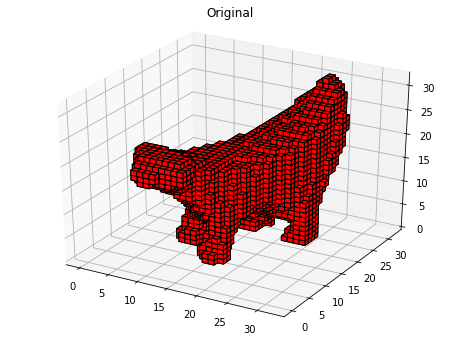

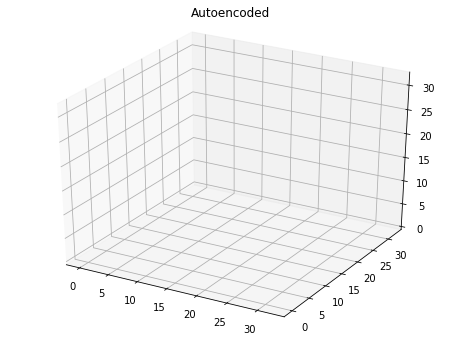

Model saved in path: C:\Users\cynth\desktop\3d-form\src\..\models\voxel_vae\model_epoch-99.ckpt


In [90]:
tf.reset_default_graph()

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=100,
                                 learning_rate=0.0001,
                                 keep_prob=1.0,
                                 kl_div_loss_weight=1,
                                 recon_loss_weight=1e4,
                                 verbose=True,
                                 debug=True)

    generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train(generator, epochs=100, input_repeats=1, display_step=10, save_step=50,
             viz_data=training_example1)
except Exception as exc:
    vae.close()
    raise(exc)

DEBUG_OP "max clipped_output": 0.1158289909362793
DEBUG_OP "min clipped_output": 0.0018151375697925687
DEBUG_OP "mean clipped_output": 0.014432486146688461


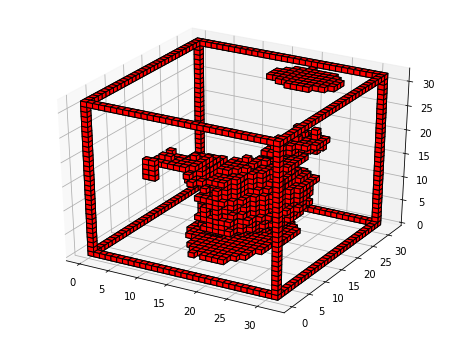

In [72]:
vox_data = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=101902),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
recon = vae.reconstruct(vox_data)
recon = np.reshape(recon, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
recon = recon > 0.028
plot_voxels(recon)

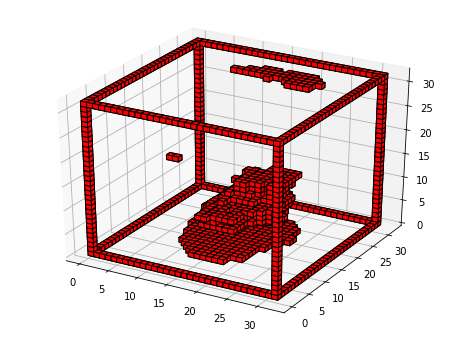

In [76]:
####### mashup two objects ###############3
# use weighted sum
vox_data_1 = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=101902),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
vox_data_2 = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=299291),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
mashup = vae.mashup(vox_data_1, vox_data_2)
mashup = np.reshape(mashup, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
mashup = mashup > 0.028
plot_voxels(mashup)

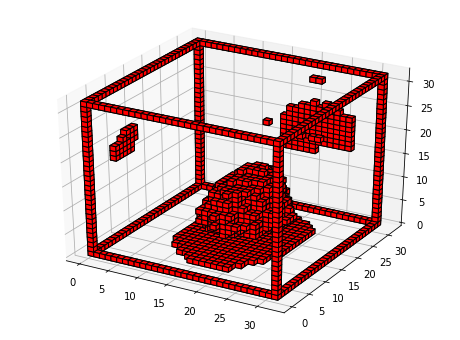

In [92]:
# use interpolation
vox_data_1 = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=101902),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
vox_data_2 = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=299291),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
mashup = vae.mashup(vox_data_1, vox_data_2)
mashup = np.reshape(mashup, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
mashup = mashup > 0.02
plot_voxels(mashup)

In [79]:
# save the stl file
from skimage import measure
output_dir = os.path.join('_output', '3d-vae-gan')
os.makedirs(output_dir, exist_ok=True)
graphs_dir = os.path.join(output_dir, 'graphs')
os.makedirs(graphs_dir, exist_ok=True)

verts, faces, normals, values = measure.marching_cubes_lewiner(mashup, 0)
save_vectors_as_stl(verts[faces], os.path.join(graphs_dir, 'mashup.stl'))

In [81]:
def interp(v1, v2, steps):

    vecs = []

    step = (v2-v1)/steps

    for i in range(steps):

        vecs.append(v1+step*i)

    vecs.append(v2)

    return vecs

In [87]:
a=np.array([1.0, 2.0, 3.0])
b=np.array([2.0, 2.0, 4.0])
c=interp(a,b,9)
c

[array([1., 2., 3.]),
 array([1.11111111, 2.        , 3.11111111]),
 array([1.22222222, 2.        , 3.22222222]),
 array([1.33333333, 2.        , 3.33333333]),
 array([1.44444444, 2.        , 3.44444444]),
 array([1.55555556, 2.        , 3.55555556]),
 array([1.66666667, 2.        , 3.66666667]),
 array([1.77777778, 2.        , 3.77777778]),
 array([1.88888889, 2.        , 3.88888889]),
 array([2., 2., 4.])]